In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy import interpolate
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
%config InlineBackend.figure_format = 'retina'

In [3]:
def extract_best_xy(file_path):
    best_x_values = []
    best_y_values = []
    
    # open the file and read by line
    with open(file_path, 'r') as f:
        for line in f:
            # use regular expressions to extract Best_x and Best_y
            best_x_match = re.search(r'Best_x = \[(.*?)\]', line)
            best_y_match = re.search(r'Best_y = ([\d\.eE+-]+)', line)
            
            if best_x_match and best_y_match:
                # extract and parse Best_x
                best_x = [float(x) for x in best_x_match.group(1).split()]
                best_y = float(best_y_match.group(1))
                
                best_x_values.append(best_x)
                best_y_values.append(best_y)
    
    return best_x_values, best_y_values


In [4]:
def generate_velocity_profile(a1, m1, v2, h1):
    """
    generare 1-d shear wave velocity profile
    
    parameters:
        a1: velocity increasing coeff
        m1: power low coeff
        h1: depth boundary between layers
        v2: initial velocity
    returns:
        h: array of depth values
        v: corresponding velocity values at each depth
    """
    h = np.arange(1, 100 + 0.2, 0.2)  # depth range from 0 to 100 with 0.5 intervel
    v = np.zeros_like(h, dtype=float)    # initial the velocity array

    h2 = 100-3-h1
    # calculate velocity for two depth regions
    for i, depth in enumerate(h):
        if 0 <= depth <= h2:
            v[i] = a1 * (depth ** m1)  # first region
        elif h2 < depth <= 100:
            v[i] = v2  # second region
    indices = np.where(h <= h2)
    v1,h1 = v[indices],h[indices]
    v3,h3 = v[indices[0][-1]+1::],h[indices[0][-1]+1::]
    
    # return np.concatenate([h1,[h1[-1]],h3]),np.concatenate([v1,[v2],v3])
    return np.concatenate([h1,h3]),np.concatenate([v1,v3])

In [5]:
file_path ='0316_new_uni.txt'

In [6]:
best_x, best_y = extract_best_xy(file_path)

In [7]:
a1, m1, v2, h1 = best_x[np.argmin(best_y)]

In [8]:
hh1, vv1 = generate_velocity_profile(a1, m1, v2, h1)

In [9]:
file_path = '0321_new_hm.txt'

In [10]:
best_x, best_y = extract_best_xy(file_path)

In [11]:
a1, m1, v2, h1 = best_x[np.argmin(best_y)]

In [12]:
hh2, vv2 = generate_velocity_profile(a1, m1, v2, h1)

In [13]:
file_path = '0328_new_obs.txt'

In [14]:
best_x, best_y = extract_best_xy(file_path)

In [15]:
a1, m1, v2, h1 = best_x[np.argmin(best_y)]

In [16]:
hh3, vv3 = generate_velocity_profile(a1, m1, v2, h1)

In [17]:
elevations = [(267,167), (270,170), (264,164)]
depths = [100, 100, 100]
x_boreholes = [0, 188, 588]

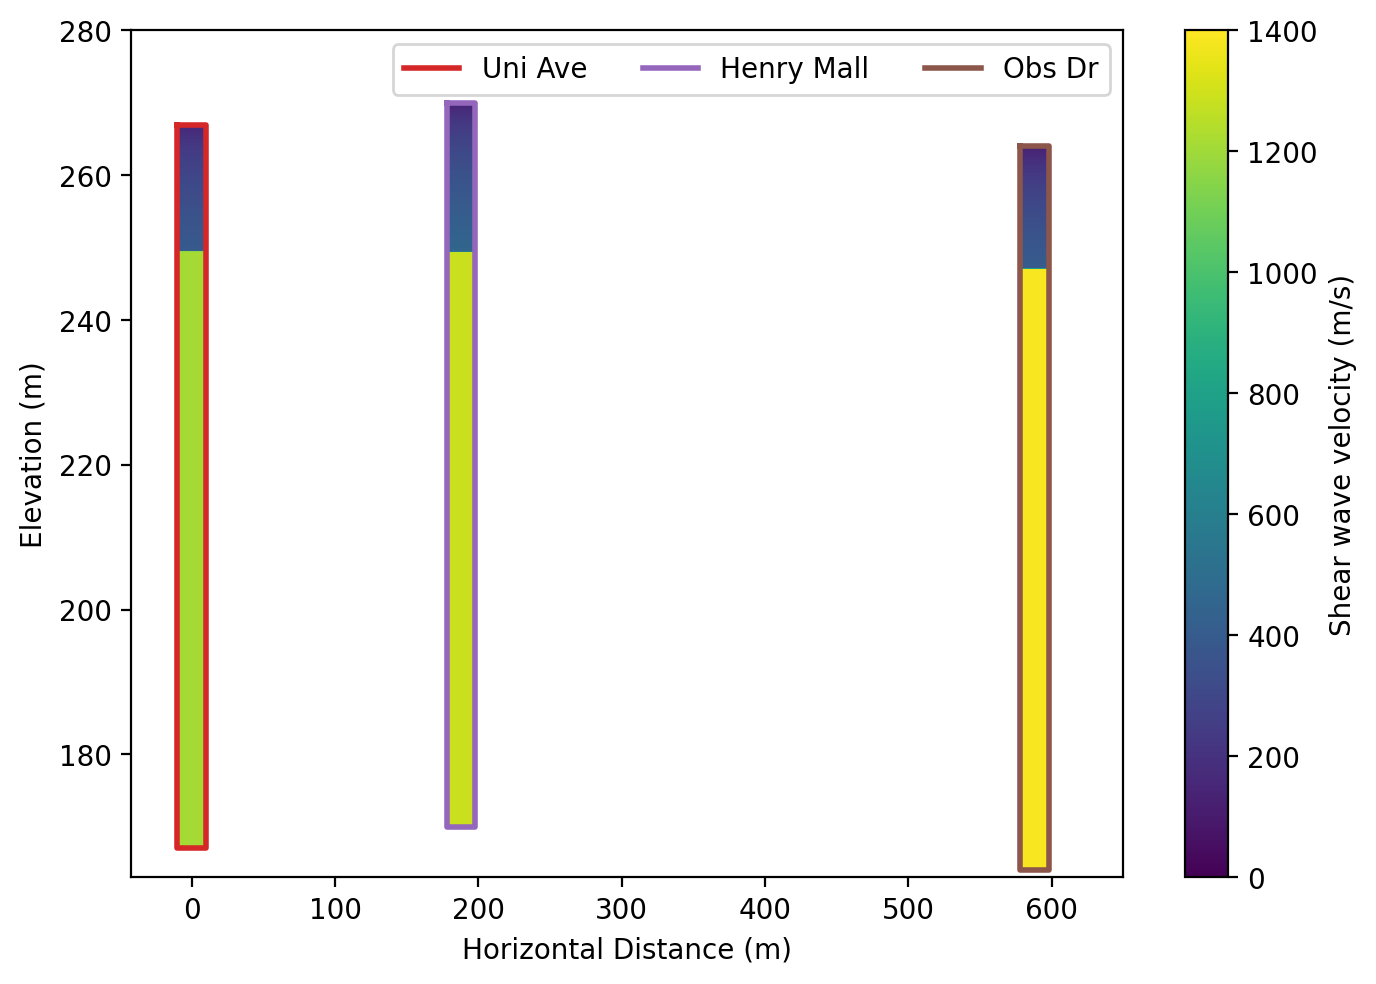

In [20]:
fig, ax = plt.subplots(figsize=(8, 5.5))
width = 20
for pos, data, elev in zip(x_boreholes, [vv1, vv2, vv3], elevations):
    top, bot = elev

    img = np.tile(data, (width, 1)).T
    cax = ax.imshow(
        img,
        extent=[pos - width/2, pos + width/2, bot, top],
        aspect='auto',
        cmap='viridis',
        vmin=0,
        vmax=1400
    )
cbar = fig.colorbar(cax, ax=ax, label='Shear wave velocity (m/s)')

cc = ['tab:red','tab:purple','tab:brown']
name = ['Uni Ave','Henry Mall', 'Obs Dr']
for i,elev in enumerate(elevations):
    top, bot = elev
    rect_x = [x_boreholes[i]-width/2, x_boreholes[i] + width/2, x_boreholes[i] + width/2, x_boreholes[i]-width/2, x_boreholes[i]-width/2]
    rect_y = [top, top, bot, bot, top]
    ax.plot(rect_x, rect_y, c = cc[i], linewidth=2,label = name[i])

ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_xlim(-42, 650)
ax.set_ylim(163, 280)
ax.legend(ncol = 3)
# plt.savefig('2d_borehole.png', dpi=600,bbox_inches = 'tight')

plt.show()